# CNN
This notebook aims to deploy the CNN.

In [42]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


---
## Loading the data
Data has to load out of the 'carolianminuscule-groundtruth'-folder 

In [44]:
def get_images(folder_path: str):
    """
    Load images and text files from the given path.
    :param folder_path: Path to the directory containing images and text files.
    :return: Two lists - one for image paths and one for text file paths.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Path {folder_path} does not exist.")

    images = []
    files = []

    for entry in os.listdir(folder_path):
        entry_path = os.path.join(folder_path, entry)
        if os.path.isdir(entry_path):
            # Recursively get images and text files from subdirectories
            sub_images, sub_files = get_images(entry_path)
            images.extend(sub_images)
            files.extend(sub_files)
        elif entry.endswith(".png"):
            images.append(entry_path)
        elif entry.endswith(".txt"):
            files.append(entry_path)

    return images, files


# load the data from the directory
path = "carolineminuscule-groundtruth"
images, files = get_images(path)


# matched the .png- and .txt-file in a folder together
matched_list_path = [
    [img, file]
    for img in images
    for file in files
    if os.path.dirname(img) == os.path.dirname(file)
    and os.path.splitext(os.path.splitext(os.path.basename(img))[0])[0]
    == os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0]
]


In [45]:
print(f"len matched: {len(matched_list_path)}")
print(f"matched_list:\n {matched_list_path[1]}")

len matched: 429
matched_list:
 ['carolineminuscule-groundtruth/bsb00095929/0011/010002.bin.png', 'carolineminuscule-groundtruth/bsb00095929/0011/010002.gt.txt']


---
## Creating the Dataset

In [46]:
# define a dataframe to store the image, image paths and their corresponding text files
df = pd.DataFrame(columns=["name", "image", "transcription"])

for i, (img_path, file_path) in enumerate(matched_list_path):
    # read the image
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    img = np.array(img)
    # add the image to the dataframe, set "none" here to add transcription later
    df.loc[i] = [os.path.basename(img_path), img, None]
    # read the text file
    with open(file_path, "r") as f:
        # read the transcription
        transcription = f.read()
    # add the transcription to the dataframe
    df.loc[i, "transcription"] = transcription

In [47]:
# delete all the linebrakes in the transcription
df["transcription"] = df["transcription"].str.replace("\n", "", regex=False)
df.head(5)

,name,image,transcription
0,010005.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",initio sicuti pleriq; studio ad empabacan
1,010002.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",gla memores que s quis: faciliafacto putat
2,010007.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",pro abstinentia ꝓuirtute audacia. largitio. au...
3,010008.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",bant. Quę tametsianimus aspꝑnabatur. insolens ...
4,010017.bin.png,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",tilinę coniuratione quam uerissime potero paucis


For now it appear that the images only have "255" as values, i.e. white. That's why im checking for other values. But the edges of the images are all white, therefore this is the exspected behaviour.

In [48]:
non_255_values = df['image'].apply(lambda img: np.any(img != 255))
print(f"Rows  in 'image' with values other than 255: {non_255_values.sum()}")

Rows  in 'image' with values other than 255: 429


---
## Preparing the data

By calculating the maximum and avg. number of the height we can use that value later in our CNN.

In [49]:
# Calculate the maximum and average length of the lists in the 'image' column
image_lengths = df['image'].apply(lambda img: img.shape[0])  # Get the height of each image array
max_length = image_lengths.max()
avg_length = image_lengths.mean()

print(f"Maximum height of an image: {max_length}")
print(f"Average height of an image: {avg_length}")

Maximum height of an image: 263
Average height of an image: 140.2004662004662


Getting the number of unique character, servs here more as an exploration into the the datas.
We stand at a pathway here: Either we manually map each of the 83 characters by hand to the according representative in the images or, use the CNN-RNN architecture. Which does not need manual character mapping, but is harder to train.

In [ ]:
# Step 1: Create a character-to-index mapping
charset = sorted(set("".join(df['transcription'])))  # Unique characters in the dataset
char_to_index = {char: idx for idx, char in enumerate(charset)}
index_to_char = {idx: char for char, idx in char_to_index.items()}
num_classes = len(charset) + 1  # Add 1 for the blank character (CTC loss)

# Step 2: Convert transcriptions to sequences of integers
label_sequences = [[char_to_index[char] for char in transcription] for transcription in df['transcription']]

# Step 3: Pad sequences to a fixed length
max_sequence_length = 64  # Adjust based on your dataset
padded_labels = pad_sequences(label_sequences, maxlen=max_sequence_length, padding='post', value=num_classes - 1)



In [51]:
# Features (images) and labels (transcriptions)
X = df["image"].values  # Images as NumPy arrays
y = df["transcription"].values  # Transcriptions as strings

In [52]:
# # Convert images to NumPy arrays and normalize
X = np.array(
     [cv2.resize(img, (512, 256)) for img in df["image"]], dtype=np.float32
 )  # Resize and convert to float32
# X = X / 255.0  # Normalize pixel values to [0, 1]
# X = X.reshape(X.shape[0], 64, 128, 1)  # Add channel dimension (grayscale images)

print(f"X shape: {X.shape}, dtype: {X.dtype}")

X shape: (429, 256, 512), dtype: float32


In [53]:
# Convert transcriptions to sequences of integers
label_sequences = [[char_to_index[char] for char in transcription] for transcription in df['transcription']]

# Pad sequences to a fixed length
max_sequence_length = 32  # Adjust based on your dataset
padded_labels = pad_sequences(label_sequences, maxlen=max_sequence_length, padding='post', value=num_classes - 1)

# Convert padded labels to one-hot encoding
y = np.array([to_categorical(seq, num_classes=num_classes) for seq in padded_labels], dtype=np.float32)

print(f"y shape: {y.shape}, dtype: {y.dtype}")

y shape: (429, 32, 84), dtype: float32


In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_classes = len(charset) + 1  # Number of unique characters

In [55]:
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train shape: (343, 256, 512), dtype: float32
y_train shape: (343, 32, 84), dtype: float32


---
## Data visualisation
Below I want to gain a better understanding of our datapoints

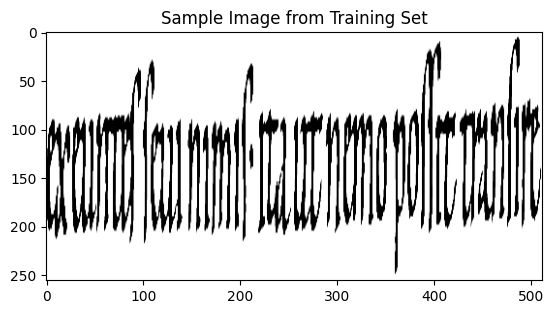

In [56]:
plt.imshow(X_train[0], cmap="gray", vmin=0, vmax=255)
plt.title("Sample Image from Training Set")
plt.show()

In [57]:
print("First entry in y_train:")
print(y_train[0])

First entry in y_train:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


---
The 'cnn_rnn'-model is comprised of an
- input layer
  - where images are read into with 64px, None and one channel
- A convolutional layer which is building 64, 3x3-filters
- Maxpooling to reduce parametersize

In [58]:
cnn_rnn = models.Sequential([
    # CNN layers
    layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(64, None, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Reshape for RNN
    layers.Reshape(target_shape=(-1, 128 * 16)),  # Adjust based on pooling and input size

    # RNN layers
    layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(256, return_sequences=True)),

    # Output layer
    layers.Dense(num_classes, activation="softmax")
])

cnn_rnn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

cnn_rnn.summary()

/home/linus/Dokumente/1_Universitaet/10_SoSe_25/SPECIALIZATION-PROEJECT/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, None, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, None, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, None, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, None, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, None, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, None, 512)      │     4,720,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 84)       │        43,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,413,140 (24.46 MB)

 Trainable params: 6,413,140 (24.46 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
#! Commented out to avoid running the model training
# # Fit the model
# cnn_rnn.fit(
#     X_train,
#     y_train,
#     epochs=10,
#     validation_data=(X_test, y_test),
# )

In [60]:
cnn_rnn.save("CNN_RNN_model.h5")